In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.genres = movies.genres.str.replace('|',' ')

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#Limit ratings dataset to users who have rated atleast 25 movies
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 25)
#Create a list of movies present in ratings dataset
#movies_list_rating = ratings_f.movieId.unique().tolist()

In [7]:
#Since the runtime for above code is high, i just saved it in a csv file so i can directly read it next time
ratings_f.to_csv('ratings_f_new.csv',index=False)
ratings_f.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
#Since the above code takes time to run, directly reading the file stored from execution before
#ratings_f = pd.read_csv('ratings_f.csv')
#ratings_f.head()

In [9]:
movies_list_rating = ratings_f.movieId.unique().tolist()
len(movies_list_rating)

9710

In [10]:
#Filter the movies dataframe
movies = movies[movies.movieId.isin(movies_list_rating)]
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
#map movies to movieId
mapping_file = dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [12]:
tags.drop(['timestamp'],inplace=True, axis =1)
ratings_f.drop(['timestamp'],inplace=True, axis=1)

In [13]:
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [14]:
#Create a new dataframe by merging movies and tags
mixed_df = pd.merge(movies,tags,on='movieId',how='left')
mixed_df.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [15]:
#There are multiple rows for each movie so we create a column metadata to store the genre and tags(which are 
#present in multiple rows) in one row
mixed_df.fillna('',inplace=True)
mixed_df = pd.DataFrame(mixed_df.groupby('movieId')['tag'].apply(lambda x = '%s' : ' '.join(x)))

In [16]:
mixed_df.head()

,tag
movieId,
1,pixar pixar fun
2,fantasy magic board game Robin Williams game
3,moldy old
4,
5,pregnancy remake


In [17]:
final_movies = pd.merge(movies,mixed_df,on='movieId',how='left')
final_movies['metadata'] = final_movies[['genres','tag']].apply(lambda x: ' '.join(x), axis=1)
final_movies.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,Comedy Romance moldy old
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake


In [18]:
#We perform tf-idf Vectorisation on metadata
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final_movies['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),index=final_movies.index.tolist())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#It is a sparse matrix with a lot of columns so we do dimensionality reduction using svd (matrix factorisation)
#We are creating one vector of 200 elements for each movie
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
latent_matrix[:2]

array([[ 1.02157892e-01,  8.30466737e-02,  6.92891574e-02,
         8.31181474e-02, -1.56902627e-01,  1.19742115e-02,
         2.35968966e-01, -9.24155125e-03, -1.21718668e-01,
        -7.52923406e-03,  2.16948545e-02,  3.04250117e-02,
         8.27881425e-03, -2.85905219e-02, -5.00228854e-02,
        -1.19202108e-02, -7.06998479e-04, -1.49009522e-03,
        -1.43348796e-02, -4.42611735e-04,  7.77764392e-06,
         5.26439458e-04,  1.45364371e-03,  3.02850217e-03,
         3.85760434e-04, -7.63078825e-04,  3.52057626e-03,
         1.53570345e-02,  6.64646740e-03,  8.67680717e-04,
         5.70754063e-04, -9.07800757e-04,  5.47366351e-03,
        -1.76792253e-03,  5.09987818e-04,  1.30984624e-03,
         2.19038093e-04, -1.01909194e-03, -9.66439410e-04,
        -1.85331069e-03,  6.49282646e-04,  1.38612810e-03,
        -1.90837879e-03,  8.97878446e-04,  5.71177098e-04,
         1.85712297e-03, -1.02434239e-02, -3.23555708e-03,
        -2.18095057e-03,  4.75841425e-03, -3.24324507e-0

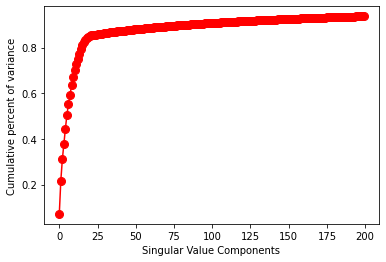

In [20]:
#Plotting to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-', ms = 16, color='red')
plt.xlabel('Singular Value Components')
plt.ylabel('Cumulative percent of variance')
plt.show()

In [21]:
n = 200
latent_matrix_l_df = pd.DataFrame(latent_matrix[:,0:n],index=final_movies.title.tolist())
latent_matrix_l_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.102158,0.083047,0.069289,0.083118,-0.156903,0.011974,0.235969,-0.009242,-0.121719,-0.007529,...,0.008104,0.153758,0.093606,0.049905,-0.056356,-0.021573,-0.057690,0.178662,-0.043725,0.154496
Jumanji (1995),0.032512,0.008901,0.058912,0.085837,-0.111296,0.007452,0.189158,-0.006138,-0.074941,0.002341,...,0.041547,-0.009117,-0.014883,0.009772,0.004641,0.008091,-0.015265,0.000399,0.004858,0.019238
Grumpier Old Men (1995),0.147929,0.105287,-0.042869,0.127408,0.091656,-0.037793,-0.011973,0.000654,0.004599,-0.002348,...,-0.002700,0.005240,0.003350,-0.010001,0.001438,0.002006,0.000277,0.007287,0.001620,0.001874
Waiting to Exhale (1995),0.825540,0.065848,-0.291994,0.391761,0.252713,-0.076026,-0.046193,-0.000831,0.027587,-0.000996,...,-0.000243,0.000088,0.000259,-0.000255,0.000135,0.000033,0.000045,-0.000314,-0.000112,-0.000050
Father of the Bride Part II (1995),0.112902,0.121176,-0.006429,-0.037674,-0.005234,0.010013,-0.009192,-0.002280,0.003953,-0.011451,...,-0.002641,0.011763,0.014033,-0.010824,-0.004475,-0.008646,0.002931,0.004708,-0.000883,-0.014039


In [22]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [23]:
ratings_f2 = pd.merge(movies.movieId,ratings_f,on='movieId',how='right')
ratings_f2.head()

,movieId,userId,rating
0,1,1,4.0
1,1,5,4.0
2,1,7,4.5
3,1,15,2.5
4,1,17,4.5


In [24]:
ratings_f3 = ratings_f2.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
ratings_f3.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Initially we ran svd directly on ratings dataset, so the latent matrix we received is only based on content
#Now we apply it on the pivot dataset we created (collaboration of different user ratings on different movies)
#So latent_matrix_l_df will give us content filtering score
#latent_mtrix_2_df will give us collaborative filtering score

In [26]:
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f3)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2[:,0:n],index=final_movies.title.tolist())
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),37.585275,-6.155013,15.178465,0.648999,-2.155746,4.309915,8.827337,-2.007258,1.225581,1.420633,...,3.573452,0.722672,1.632020,2.261332,0.259162,0.046319,-0.056870,1.233694,0.983228,-0.814186
Jumanji (1995),20.597430,-0.377713,11.171060,-8.412376,-3.262700,-1.017595,4.342063,-4.025289,-3.277966,0.285516,...,-2.730286,0.578989,-0.228878,-0.511517,-0.782679,-0.325666,0.352837,-0.985332,1.456799,1.224710
Grumpier Old Men (1995),8.491590,-5.660520,3.662447,-6.338464,-0.065760,-0.958899,-1.445176,-0.497546,3.263444,1.925481,...,0.196490,1.137030,-0.163634,-0.517456,-1.359726,0.427319,-0.733093,0.464570,-1.232711,-0.145068
Waiting to Exhale (1995),0.465413,-0.818077,0.971509,-0.218960,-0.719577,-0.944040,0.205715,-0.548523,0.097429,0.028577,...,-0.120117,0.082696,-0.460845,-0.005915,0.160222,0.202427,0.553448,-0.290361,0.476089,0.255283
Father of the Bride Part II (1995),6.042813,-2.574425,4.788804,-4.298316,-3.807926,-1.995422,1.238834,-1.358939,1.353082,1.267101,...,0.346221,0.263573,-0.339194,0.477037,0.586288,-1.097513,0.880717,0.219619,-0.999675,0.219295


In [28]:
#We run a content/collaborative and hybrid Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
#take the latent vectors for a selected movie
a_1 = np.array(latent_matrix_l_df.loc['Grumpier Old Men (1995)']).reshape(1,-1)
a_2 = np.array(latent_matrix_2_df.loc['Grumpier Old Men (1995)']).reshape(1,-1)

#Calculate the Similarity of this movie with the others in the list
content_score = cosine_similarity(latent_matrix_l_df,a_1).reshape(-1)
collaborative_score = cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)
hybrid_score = (content_score+collaborative_score)/2

#Form a dataframe with the score
dictdf = {'content' : content_score, 'collaborative' : collaborative_score, 'hybrid' : hybrid_score}
score_df = pd.DataFrame(dictdf,index=latent_matrix_l_df.index)
score_df.sort_values('hybrid', ascending=False, inplace=True)
score_df[1:].head(10)

,content,collaborative,hybrid
"Truth About Cats & Dogs, The (1996)",0.993611,0.511127,0.752369
Nine Months (1995),0.995653,0.451103,0.723378
Milk Money (1994),0.995653,0.431949,0.713801
I.Q. (1994),0.994009,0.395676,0.694842
She's the One (1996),0.995653,0.379670,0.687662
Son in Law (1993),0.880523,0.473734,0.677129
Better Off Dead... (1985),0.989320,0.337793,0.663556
Two if by Sea (1996),0.995653,0.330035,0.662844
"Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)",0.995653,0.319663,0.657658
Blind Date (1987),0.995653,0.319487,0.657570
